🎯 APT41 THREAT HUNTING NOTEBOOK
📍 Target: 192.168.1.51
🕐 Current Time: 2025-12-08 19:05:22 EST
🕐 Hunt Period: Last 48 hours

🔌 Testing connection to Wazuh...
✓ Connected to Wazuh
  Cluster: wazuh-cluster
  Version: 7.10.2
  Total alerts: 2,211,561

✓ Ready for hunting!
✓ Utility functions loaded
  - search_wazuh()
  - display_results()
  - get_time_range()

🔍 HUNT 1: T1550.002 - Pass-the-Hash

📊 T1550.002 - Pass-the-Hash
   Total detections: 7532
   Showing 50 recent events:

               Time       Agent      Agent_IP Event_ID         User Source_IP  Rule  Level         Description
2025-12-08 15:25:46 SDC01VIRW22  192.168.20.2     4634 SDC01VIRW22$       N/A 60137      3 Windows User Logoff
2025-12-08 15:24:49 SDC01VIRW22  192.168.20.2     4634 SDC01VIRW22$       N/A 60137      3 Windows User Logoff
2025-12-08 15:24:46 SDC01VIRW22  192.168.20.2     4634 SDC01VIRW22$       N/A 60137      3 Windows User Logoff
2025-12-08 15:24:35 SDC01VIRW22  192.168.20.2     4634 SDC01VIRW22$       N

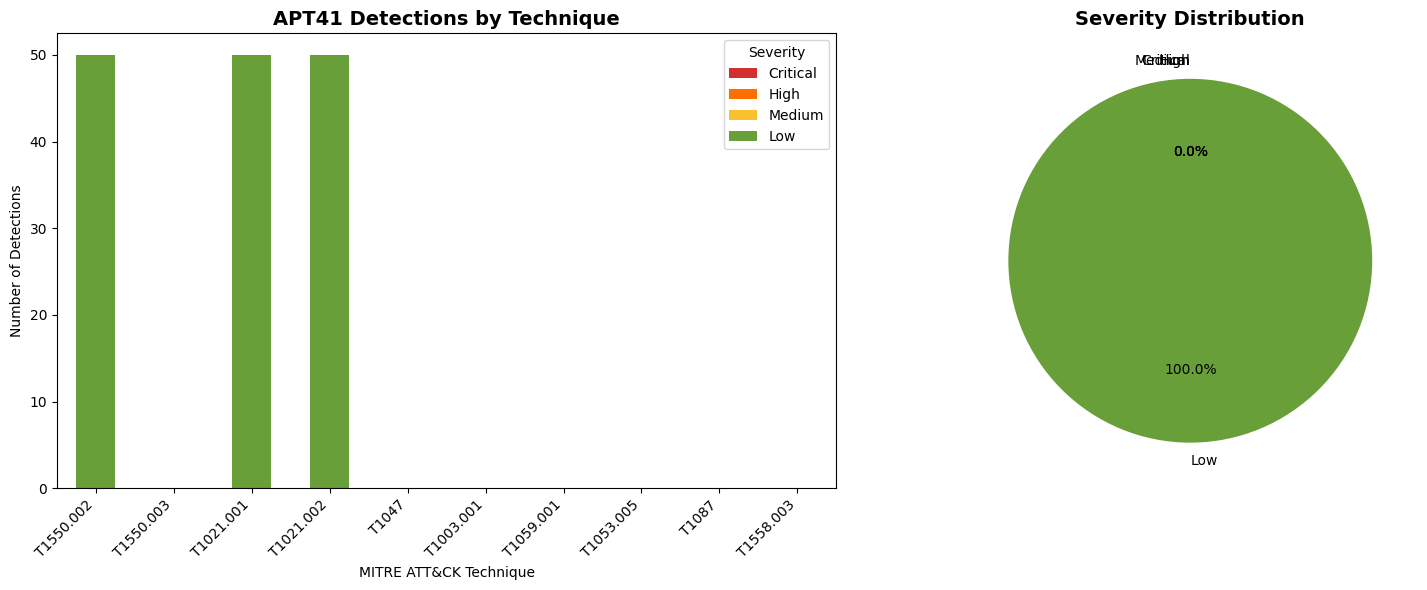


✓ Visualization generated

💾 EXPORTING REPORT
✓ JSON: apt41_report_20251208_190522.json
✓ CSV: apt41_summary_20251208_190522.csv
✓ Detailed CSVs: 3 files
✓ HTML: apt41_report_20251208_190522.html

✅ HUNT COMPLETE

📂 Reports saved in: /home/jovyan/work/apt41_reports
🕐 Local time: 2025-12-08 19:05:22 EST

💡 Access: File Browser → work → apt41_reports


In [1]:
"""
APT41 Threat Hunting Notebook
Techniques: T1550.002, T1550.003, T1021.001, T1021.002, T1047
"""
import os
import sys
import time
import logging

import requests
import urllib3
import json
import pandas as pd
from datetime import datetime, timedelta
import warnings
import pytz

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
warnings.filterwarnings('ignore')

# ============================================================
# CONFIGURATION - MODIFIER ICI
# ============================================================
WAZUH_IP = "192.168.1.51"
WAZUH_USER = "brahim"
WAZUH_PASS = "C@nada@2025"

# TIMEZONE CONFIGURATION
LOCAL_TZ = pytz.timezone('America/Toronto')  # EST/EDT

# Période de chasse (dernières 24h par défaut)
HUNT_HOURS = 48

# Get current time in local timezone
now_local = datetime.now(LOCAL_TZ)

print("=" * 70)
print("🎯 APT41 THREAT HUNTING NOTEBOOK")
print("=" * 70)
print(f"📍 Target: {WAZUH_IP}")
print(f"🕐 Current Time: {now_local.strftime('%Y-%m-%d %H:%M:%S %Z')}")
print(f"🕐 Hunt Period: Last {HUNT_HOURS} hours")
print("=" * 70)

# Test de connexion
print("\n🔌 Testing connection to Wazuh...")

try:
    response = requests.get(
        f'https://{WAZUH_IP}:9200',
        auth=(WAZUH_USER, WAZUH_PASS),
        verify=False,
        timeout=10
    )
    
    if response.status_code == 200:
        info = response.json()
        print("✓ Connected to Wazuh")
        print(f"  Cluster: {info['cluster_name']}")
        print(f"  Version: {info['version']['number']}")
        
        # Count total alerts
        count_response = requests.get(
            f'https://{WAZUH_IP}:9200/wazuh-alerts-*/_count',
            auth=(WAZUH_USER, WAZUH_PASS),
            verify=False,
            timeout=10
        )
        
        if count_response.status_code == 200:
            count = count_response.json()['count']
            print(f"  Total alerts: {count:,}")
            print("\n✓ Ready for hunting!")
        else:
            print(f"⚠ Warning: Cannot count alerts ({count_response.status_code})")
    else:
        print(f"✗ Connection failed: HTTP {response.status_code}")
        print("  Check your credentials and IP address")
        
except Exception as e:
    print(f"✗ Connection error: {e}")
    print("\n⚠️  Check:")
    print("  1. WAZUH_IP is correct")
    print("  2. WAZUH_USER is correct")
    print("  3. WAZUH_PASS is correct")
    print("  4. Wazuh is accessible from this network")

# ============================================================
# UTILITY FUNCTIONS
# ============================================================

def search_wazuh(query, size=100):
    """Execute search query on Wazuh"""
    url = f'https://{WAZUH_IP}:9200/wazuh-alerts-*/_search'
    
    try:
        response = requests.post(
            url,
            auth=(WAZUH_USER, WAZUH_PASS),
            json=query,
            verify=False,
            headers={'Content-Type': 'application/json'},
            timeout=30
        )
        
        if response.status_code == 200:
            return response.json()
        else:
            print(f"⚠ Search error: HTTP {response.status_code}")
            return None
            
    except Exception as e:
        print(f"✗ Search failed: {e}")
        return None

def display_results(results, technique_id, technique_name):
    """Display search results in a formatted table"""
    
    if not results or 'hits' not in results:
        print(f"✗ No results for {technique_id}")
        return None
    
    total = results['hits']['total']['value']
    hits = results['hits']['hits']
    
    print(f"\n📊 {technique_id} - {technique_name}")
    print(f"   Total detections: {total}")
    
    if total == 0:
        print("   ✓ No threats detected (clean)")
        return None
    
    print(f"   Showing {len(hits)} recent events:\n")
    
    # Extract data for DataFrame
    data = []
    for hit in hits:
        alert = hit['_source']
        
        # Parse timestamp and convert to local timezone
        ts = alert.get('timestamp', 'N/A')
        if ts != 'N/A':
            try:
                # Parse UTC timestamp
                ts_utc = datetime.fromisoformat(ts.replace('Z', '+00:00'))
                # Convert to local timezone
                ts_local = ts_utc.astimezone(LOCAL_TZ)
                ts = ts_local.strftime('%Y-%m-%d %H:%M:%S')
            except:
                pass
        
        data.append({
            'Time': ts,
            'Agent': alert.get('agent', {}).get('name', 'Unknown')[:20],
            'Agent_IP': alert.get('agent', {}).get('ip', 'Unknown'),
            'Event_ID': alert.get('data', {}).get('win', {}).get('system', {}).get('eventID', 'N/A'),
            'User': alert.get('data', {}).get('win', {}).get('eventdata', {}).get('targetUserName', 'N/A')[:20],
            'Source_IP': alert.get('data', {}).get('win', {}).get('eventdata', {}).get('ipAddress', 'N/A'),
            'Rule': alert.get('rule', {}).get('id', 'N/A'),
            'Level': alert.get('rule', {}).get('level', 0),
            'Description': alert.get('rule', {}).get('description', 'No description')[:60]
        })
    
    df = pd.DataFrame(data)
    
    # Display
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 60)
    
    print(df.to_string(index=False))
    
    return df

def get_time_range():
    """Get hunt time range in local timezone"""
    end_time = datetime.now(LOCAL_TZ)
    start_time = end_time - timedelta(hours=HUNT_HOURS)
    return start_time, end_time

# Initialize results storage
hunt_results = {}

print("✓ Utility functions loaded")
print("  - search_wazuh()")
print("  - display_results()")
print("  - get_time_range()")


# ============================================================
# T1550.002 - PASS-THE-HASH (PtH)
# ============================================================

print("\n" + "=" * 70)
print("🔍 HUNT 1: T1550.002 - Pass-the-Hash")
print("=" * 70)

start_time, end_time = get_time_range()

query = {
    'query': {
        'bool': {
            'must': [
                {'range': {'timestamp': {
                    'gte': start_time.isoformat(),
                    'lte': end_time.isoformat()
                }}}
            ],
            'should': [
                # Event 4624 with NTLM
                {'bool': {'must': [
                    {'term': {'data.win.system.eventID': '4624'}},
                    {'terms': {'data.win.eventdata.logonType': ['3', '9']}},
                    {'wildcard': {'data.win.eventdata.authenticationPackageName': '*NTLM*'}}
                ]}},
                # Event 4648 - Explicit credentials
                {'term': {'data.win.system.eventID': '4648'}},
                # Event 4776 - NTLM auth
                {'term': {'data.win.system.eventID': '4776'}},
                # Wazuh PtH rules
                {'terms': {'rule.id': ['60137', '60138', '184665']}}
            ],
            'minimum_should_match': 1
        }
    },
    'size': 50,
    'sort': [{'timestamp': {'order': 'desc'}}]
}

results = search_wazuh(query)
df_pth = display_results(results, 'T1550.002', 'Pass-the-Hash')

if df_pth is not None:
    hunt_results['T1550.002'] = {
        'name': 'Pass-the-Hash',
        'count': len(df_pth),
        'data': df_pth
    }
    
    # Statistics
    print(f"\n   📈 Statistics:")
    print(f"      Affected agents: {df_pth['Agent'].nunique()}")
    print(f"      Unique users: {df_pth['User'].nunique()}")
    if 'Source_IP' in df_pth.columns:
        print(f"      Source IPs: {df_pth['Source_IP'].nunique()}")
else:
    hunt_results['T1550.002'] = {'name': 'Pass-the-Hash', 'count': 0, 'data': None}

# ============================================================
# T1550.003 - PASS-THE-TICKET (PtT)
# ============================================================

print("\n" + "=" * 70)
print("🔍 HUNT 2: T1550.003 - Pass-the-Ticket")
print("=" * 70)

query = {
    'query': {
        'bool': {
            'must': [
                {'range': {'timestamp': {
                    'gte': start_time.isoformat(),
                    'lte': end_time.isoformat()
                }}}
            ],
            'should': [
                # Event 4768 - TGT with weak encryption
                {'bool': {'must': [
                    {'term': {'data.win.system.eventID': '4768'}},
                    {'terms': {'data.win.eventdata.ticketEncryptionType': ['0x17', '0x18']}}
                ]}},
                # Event 4769 - Service ticket
                {'bool': {'must': [
                    {'term': {'data.win.system.eventID': '4769'}},
                    {'terms': {'data.win.eventdata.ticketEncryptionType': ['0x17', '0x18']}}
                ]}},
                # Mimikatz kerberos
                {'wildcard': {'data.win.eventdata.commandLine': '*kerberos::ptt*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*kerberos::list*'}},
                # Rubeus
                {'wildcard': {'data.win.eventdata.commandLine': '*rubeus*ptt*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*rubeus*asktgt*'}}
            ],
            'minimum_should_match': 1
        }
    },
    'size': 50,
    'sort': [{'timestamp': {'order': 'desc'}}]
}

results = search_wazuh(query)
df_ptt = display_results(results, 'T1550.003', 'Pass-the-Ticket')

if df_ptt is not None:
    hunt_results['T1550.003'] = {
        'name': 'Pass-the-Ticket',
        'count': len(df_ptt),
        'data': df_ptt
    }
    
    print(f"\n   📈 Statistics:")
    print(f"      Affected agents: {df_ptt['Agent'].nunique()}")
    print(f"      Event types: {df_ptt['Event_ID'].value_counts().to_dict()}")
else:
    hunt_results['T1550.003'] = {'name': 'Pass-the-Ticket', 'count': 0, 'data': None}


# ============================================================
# T1021.001 - REMOTE DESKTOP PROTOCOL (RDP)
# ============================================================

print("\n" + "=" * 70)
print("🔍 HUNT 3: T1021.001 - RDP Lateral Movement")
print("=" * 70)

query = {
    'query': {
        'bool': {
            'must': [
                {'range': {'timestamp': {
                    'gte': start_time.isoformat(),
                    'lte': end_time.isoformat()
                }}}
            ],
            'should': [
                # Event 4624 LogonType 10
                {'bool': {'must': [
                    {'term': {'data.win.system.eventID': '4624'}},
                    {'term': {'data.win.eventdata.logonType': '10'}}
                ]}},
                # Event 4778 - RDP reconnect
                {'term': {'data.win.system.eventID': '4778'}},
                # Event 4779 - RDP disconnect
                {'term': {'data.win.system.eventID': '4779'}},
                # Wazuh RDP rules
                {'terms': {'rule.id': ['60106', '60122', '60204', '60144']}}
            ],
            'minimum_should_match': 1
        }
    },
    'size': 50,
    'sort': [{'timestamp': {'order': 'desc'}}]
}

results = search_wazuh(query)
df_rdp = display_results(results, 'T1021.001', 'RDP Lateral Movement')

if df_rdp is not None:
    hunt_results['T1021.001'] = {
        'name': 'RDP Lateral Movement',
        'count': len(df_rdp),
        'data': df_rdp
    }
    
    print(f"\n   📈 Statistics:")
    print(f"      Affected agents: {df_rdp['Agent'].nunique()}")
    print(f"      Unique users: {df_rdp['User'].nunique()}")
    
    # Top RDP sources
    if 'Source_IP' in df_rdp.columns:
        top_sources = df_rdp['Source_IP'].value_counts().head(5)
        print(f"\n   🔝 Top source IPs:")
        for ip, count in top_sources.items():
            print(f"      {ip}: {count} connections")
else:
    hunt_results['T1021.001'] = {'name': 'RDP Lateral Movement', 'count': 0, 'data': None}


# ============================================================
# T1021.002 - SMB/WINDOWS ADMIN SHARES (PsExec)
# ============================================================

print("\n" + "=" * 70)
print("🔍 HUNT 4: T1021.002 - SMB/PsExec")
print("=" * 70)

query = {
    'query': {
        'bool': {
            'must': [
                {'range': {'timestamp': {
                    'gte': start_time.isoformat(),
                    'lte': end_time.isoformat()
                }}}
            ],
            'should': [
                # Event 5140 - Admin share access
                {'bool': {'must': [
                    {'term': {'data.win.system.eventID': '5140'}},
                    {'regexp': {'data.win.eventdata.shareName': '.*ADMIN\\$|.*C\\$|.*IPC\\$.*'}}
                ]}},
                # Event 7045 - PSEXESVC service
                {'bool': {'must': [
                    {'term': {'data.win.system.eventID': '7045'}},
                    {'wildcard': {'data.win.eventdata.serviceName': '*PSEXESVC*'}}
                ]}},
                # PsExec execution
                {'wildcard': {'data.win.eventdata.image': '*psexec.exe'}},
                {'wildcard': {'data.win.eventdata.image': '*PSEXESVC.exe'}},
                # Wazuh SMB rules
                {'terms': {'rule.id': ['18103', '18104', '184665']}}
            ],
            'minimum_should_match': 1
        }
    },
    'size': 50,
    'sort': [{'timestamp': {'order': 'desc'}}]
}

results = search_wazuh(query)
df_smb = display_results(results, 'T1021.002', 'SMB/PsExec')

if df_smb is not None:
    hunt_results['T1021.002'] = {
        'name': 'SMB/PsExec',
        'count': len(df_smb),
        'data': df_smb
    }
    
    print(f"\n   📈 Statistics:")
    print(f"      Affected agents: {df_smb['Agent'].nunique()}")
    print(f"      Event types: {df_smb['Event_ID'].value_counts().to_dict()}")
else:
    hunt_results['T1021.002'] = {'name': 'SMB/PsExec', 'count': 0, 'data': None}

# ============================================================
# T1003.001 - LSASS Memory Dumping
# ============================================================

print("\n" + "=" * 70)
print("🔍 HUNT 6: T1003.001 - LSASS Memory Dumping")
print("=" * 70)

query = {
    'query': {
        'bool': {
            'must': [
                {'range': {'timestamp': {
                    'gte': start_time.isoformat(),
                    'lte': end_time.isoformat()
                }}}
            ],
            'should': [
                # Sysmon Event 10 - Process Access to LSASS
                {'bool': {'must': [
                    {'term': {'data.win.system.eventID': '10'}},
                    {'wildcard': {'data.win.eventdata.targetImage': '*lsass.exe'}}
                ]}},
                # Suspicious granted access
                {'terms': {'data.win.eventdata.grantedAccess': ['0x1410', '0x1010', '0x1438', '0x143a', '0x1fffff']}},
                # Mimikatz
                {'wildcard': {'data.win.eventdata.commandLine': '*sekurlsa*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*logonpasswords*'}},
                # Procdump on lsass
                {'bool': {'must': [
                    {'wildcard': {'data.win.eventdata.image': '*procdump*'}},
                    {'wildcard': {'data.win.eventdata.commandLine': '*lsass*'}}
                ]}},
                # Wazuh rules
                {'terms': {'rule.id': ['184666', '61603', '61604']}}
            ],
            'minimum_should_match': 1
        }
    },
    'size': 50,
    'sort': [{'timestamp': {'order': 'desc'}}]
}

results = search_wazuh(query)
df_lsass = display_results(results, 'T1003.001', 'LSASS Memory Dumping')

if df_lsass is not None:
    hunt_results['T1003.001'] = {
        'name': 'LSASS Memory Dumping',
        'count': len(df_lsass),
        'data': df_lsass
    }
    print(f"\n   📈 Statistics:")
    print(f"      Affected agents: {df_lsass['Agent'].nunique()}")
else:
    hunt_results['T1003.001'] = {'name': 'LSASS Memory Dumping', 'count': 0, 'data': None}

# ============================================================
# T1558.003 - Kerberoasting
# ============================================================

print("\n" + "=" * 70)
print("🔍 HUNT 10: T1558.003 - Kerberoasting")
print("=" * 70)

query = {
    'query': {
        'bool': {
            'must': [
                {'range': {'timestamp': {
                    'gte': start_time.isoformat(),
                    'lte': end_time.isoformat()
                }}}
            ],
            'should': [
                # Event 4769 with RC4 encryption
                {'bool': {'must': [
                    {'term': {'data.win.system.eventID': '4769'}},
                    {'term': {'data.win.eventdata.ticketEncryptionType': '0x17'}},
                    {'bool': {'must_not': [
                        {'wildcard': {'data.win.eventdata.serviceName': '*$'}}
                    ]}}
                ]}},
                # Rubeus kerberoast
                {'wildcard': {'data.win.eventdata.commandLine': '*rubeus*kerberoast*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*invoke-kerberoast*'}}
            ],
            'minimum_should_match': 1
        }
    },
    'size': 50,
    'sort': [{'timestamp': {'order': 'desc'}}]
}

results = search_wazuh(query)
df_kerb = display_results(results, 'T1558.003', 'Kerberoasting')

if df_kerb is not None:
    hunt_results['T1558.003'] = {
        'name': 'Kerberoasting',
        'count': len(df_kerb),
        'data': df_kerb
    }
else:
    hunt_results['T1558.003'] = {'name': 'Kerberoasting', 'count': 0, 'data': None}
# ============================================================
# T1059.001 - PowerShell
# ============================================================

print("\n" + "=" * 70)
print("🔍 HUNT 7: T1059.001 - Suspicious PowerShell")
print("=" * 70)

query = {
    'query': {
        'bool': {
            'must': [
                {'range': {'timestamp': {
                    'gte': start_time.isoformat(),
                    'lte': end_time.isoformat()
                }}},
                {'wildcard': {'data.win.eventdata.image': '*powershell.exe'}}
            ],
            'should': [
                {'wildcard': {'data.win.eventdata.commandLine': '*-enc*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*-encodedcommand*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*-w hidden*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*bypass*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*IEX*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*downloadstring*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*invoke-expression*'}}
            ],
            'minimum_should_match': 1
        }
    },
    'size': 50,
    'sort': [{'timestamp': {'order': 'desc'}}]
}

results = search_wazuh(query)
df_ps = display_results(results, 'T1059.001', 'Suspicious PowerShell')

if df_ps is not None:
    hunt_results['T1059.001'] = {
        'name': 'Suspicious PowerShell',
        'count': len(df_ps),
        'data': df_ps
    }
else:
    hunt_results['T1059.001'] = {'name': 'Suspicious PowerShell', 'count': 0, 'data': None}

# ============================================================
# T1053.005 - Scheduled Task
# ============================================================

print("\n" + "=" * 70)
print("🔍 HUNT 8: T1053.005 - Scheduled Task")
print("=" * 70)

query = {
    'query': {
        'bool': {
            'must': [
                {'range': {'timestamp': {
                    'gte': start_time.isoformat(),
                    'lte': end_time.isoformat()
                }}}
            ],
            'should': [
                # schtasks.exe creation
                {'bool': {'must': [
                    {'wildcard': {'data.win.eventdata.image': '*schtasks.exe'}},
                    {'wildcard': {'data.win.eventdata.commandLine': '*/create*'}}
                ]}},
                # Event 4698 - Scheduled task created
                {'term': {'data.win.system.eventID': '4698'}},
                # Suspicious paths
                {'wildcard': {'data.win.eventdata.commandLine': '*\\temp\\*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*\\appdata\\*'}}
            ],
            'minimum_should_match': 1
        }
    },
    'size': 50,
    'sort': [{'timestamp': {'order': 'desc'}}]
}

results = search_wazuh(query)
df_schtask = display_results(results, 'T1053.005', 'Scheduled Task')

if df_schtask is not None:
    hunt_results['T1053.005'] = {
        'name': 'Scheduled Task',
        'count': len(df_schtask),
        'data': df_schtask
    }
else:
    hunt_results['T1053.005'] = {'name': 'Scheduled Task', 'count': 0, 'data': None}

# ============================================================
# T1087 - Account Discovery
# ============================================================

print("\n" + "=" * 70)
print("🔍 HUNT 9: T1087 - Account Discovery")
print("=" * 70)

query = {
    'query': {
        'bool': {
            'must': [
                {'range': {'timestamp': {
                    'gte': start_time.isoformat(),
                    'lte': end_time.isoformat()
                }}},
                {'term': {'data.win.system.eventID': '1'}}
            ],
            'should': [
                {'wildcard': {'data.win.eventdata.commandLine': '*net user*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*net localgroup*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*net group*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*whoami*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*query user*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*dsquery*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*nltest*'}}
            ],
            'minimum_should_match': 1
        }
    },
    'size': 50,
    'sort': [{'timestamp': {'order': 'desc'}}]
}

results = search_wazuh(query)
df_recon = display_results(results, 'T1087', 'Account Discovery')

if df_recon is not None:
    hunt_results['T1087'] = {
        'name': 'Account Discovery',
        'count': len(df_recon),
        'data': df_recon
    }
else:
    hunt_results['T1087'] = {'name': 'Account Discovery', 'count': 0, 'data': None}

# ============================================================
# T1558.003 - Kerberoasting
# ============================================================

print("\n" + "=" * 70)
print("🔍 HUNT 10: T1558.003 - Kerberoasting")
print("=" * 70)

query = {
    'query': {
        'bool': {
            'must': [
                {'range': {'timestamp': {
                    'gte': start_time.isoformat(),
                    'lte': end_time.isoformat()
                }}}
            ],
            'should': [
                # Event 4769 with RC4 encryption
                {'bool': {'must': [
                    {'term': {'data.win.system.eventID': '4769'}},
                    {'term': {'data.win.eventdata.ticketEncryptionType': '0x17'}},
                    {'bool': {'must_not': [
                        {'wildcard': {'data.win.eventdata.serviceName': '*$'}}
                    ]}}
                ]}},
                # Rubeus kerberoast
                {'wildcard': {'data.win.eventdata.commandLine': '*rubeus*kerberoast*'}},
                {'wildcard': {'data.win.eventdata.commandLine': '*invoke-kerberoast*'}}
            ],
            'minimum_should_match': 1
        }
    },
    'size': 50,
    'sort': [{'timestamp': {'order': 'desc'}}]
}

results = search_wazuh(query)
df_kerb = display_results(results, 'T1558.003', 'Kerberoasting')

if df_kerb is not None:
    hunt_results['T1558.003'] = {
        'name': 'Kerberoasting',
        'count': len(df_kerb),
        'data': df_kerb
    }
else:
    hunt_results['T1558.003'] = {'name': 'Kerberoasting', 'count': 0, 'data': None}

# ============================================================
# T1047 - WINDOWS MANAGEMENT INSTRUMENTATION (WMI)
# ============================================================

print("\n" + "=" * 70)
print("🔍 HUNT 5: T1047 - WMI Execution")
print("=" * 70)

query = {
    'query': {
        'bool': {
            'must': [
                {'range': {'timestamp': {
                    'gte': start_time.isoformat(),
                    'lte': end_time.isoformat()
                }}}
            ],
            'should': [
                # wmic.exe with /node
                {'bool': {'must': [
                    {'term': {'data.win.system.eventID': '1'}},
                    {'wildcard': {'data.win.eventdata.image': '*wmic.exe'}},
                    {'wildcard': {'data.win.eventdata.commandLine': '*/node:*'}}
                ]}},
                # wmic process call create
                {'bool': {'must': [
                    {'wildcard': {'data.win.eventdata.image': '*wmic.exe'}},
                    {'wildcard': {'data.win.eventdata.commandLine': '*process*call*create*'}}
                ]}},
                # wmiprvse.exe spawning processes
                {'bool': {'must': [
                    {'term': {'data.win.system.eventID': '1'}},
                    {'wildcard': {'data.win.eventdata.parentImage': '*wmiprvse.exe'}}
                ]}},
                # WMI Event IDs
                {'terms': {'data.win.system.eventID': ['5857', '5858', '5859']}},
                # Wazuh WMI rules
                {'terms': {'rule.id': ['18158', '18159', '92005']}}
            ],
            'minimum_should_match': 1
        }
    },
    'size': 50,
    'sort': [{'timestamp': {'order': 'desc'}}]
}

results = search_wazuh(query)
df_wmi = display_results(results, 'T1047', 'WMI Execution')

if df_wmi is not None:
    hunt_results['T1047'] = {
        'name': 'WMI Execution',
        'count': len(df_wmi),
        'data': df_wmi
    }
    
    print(f"\n   📈 Statistics:")
    print(f"      Affected agents: {df_wmi['Agent'].nunique()}")
    print(f"      Event types: {df_wmi['Event_ID'].value_counts().to_dict()}")
else:
    hunt_results['T1047'] = {'name': 'WMI Execution', 'count': 0, 'data': None}



# ============================================================
# SUMMARY AND VISUALIZATION
# ============================================================

print("\n" + "=" * 70)
print("📊 GLOBAL SUMMARY - APT41 THREAT HUNTING")
print("=" * 70)

# Create summary DataFrame
summary_data = []
total_detections = 0

#for tech_id in ['T1550.002', 'T1550.003', 'T1021.001', 'T1021.002', 'T1047']:
for tech_id in ['T1550.002', 'T1550.003', 'T1021.001', 'T1021.002', 'T1047', 
                'T1003.001', 'T1059.001', 'T1053.005', 'T1087', 'T1558.003']:
    if tech_id in hunt_results:
        result = hunt_results[tech_id]
        count = result['count']
        total_detections += count
        
        # Count by severity
        df = result['data']
        if df is not None and 'Level' in df.columns:
            critical = len(df[df['Level'] >= 12])
            high = len(df[(df['Level'] >= 10) & (df['Level'] < 12)])
            medium = len(df[(df['Level'] >= 5) & (df['Level'] < 10)])
            low = len(df[df['Level'] < 5])
        else:
            critical = high = medium = low = 0
        
        summary_data.append({
            'Technique': f"{tech_id}",
            'Name': result['name'],
            'Total': count,
            'Critical': critical,
            'High': high,
            'Medium': medium,
            'Low': low
        })

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

print(f"\n🎯 Total Detections: {total_detections}")
print(f"🕐 Hunt Period: {start_time.strftime('%Y-%m-%d %H:%M %Z')} → {end_time.strftime('%Y-%m-%d %H:%M %Z')}")

# Visualization
if total_detections > 0:
    try:
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Chart 1: Detections by technique
        df_summary.plot(
            x='Technique', 
            y=['Critical', 'High', 'Medium', 'Low'],
            kind='bar', 
            stacked=True, 
            ax=ax1,
            color=['#d32f2f', '#ff6f00', '#fbc02d', '#689f38']
        )
        ax1.set_title('APT41 Detections by Technique', fontsize=14, fontweight='bold')
        ax1.set_xlabel('MITRE ATT&CK Technique')
        ax1.set_ylabel('Number of Detections')
        ax1.legend(title='Severity', loc='upper right')
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Chart 2: Distribution by severity
        severity_total = df_summary[['Critical', 'High', 'Medium', 'Low']].sum()
        colors = ['#d32f2f', '#ff6f00', '#fbc02d', '#689f38']
        ax2.pie(severity_total, labels=severity_total.index, autopct='%1.1f%%',
                colors=colors, startangle=90)
        ax2.set_title('Severity Distribution', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("\n✓ Visualization generated")
        
    except Exception as e:
        print(f"\n⚠ Could not generate visualization: {e}")
else:
    print("\n✓ No threats detected - System appears clean")


# ============================================================
# EXPORT REPORT (FIXED PERMISSIONS)
# ============================================================

print("\n" + "=" * 70)
print("💾 EXPORTING REPORT")
print("=" * 70)

# Use work directory with proper permissions
reports_dir = '/home/jovyan/work/apt41_reports'
os.makedirs(reports_dir, exist_ok=True)

timestamp = now_local.strftime('%Y%m%d_%H%M%S')

# JSON Report
json_report = {
    'metadata': {
        'report_type': 'APT41 Threat Hunting',
        'generated_at': now_local.isoformat(),
        'timezone': 'America/Toronto',
        'hunt_period': {
            'start': start_time.strftime('%Y-%m-%d %H:%M:%S %Z'),
            'end': end_time.strftime('%Y-%m-%d %H:%M:%S %Z'),
            'duration_hours': HUNT_HOURS
        },
        'target': WAZUH_IP
    },
    'summary': {
        'total_detections': total_detections,
        'techniques_detected': len([r for r in hunt_results.values() if r['count'] > 0]),
        'techniques': summary_data
    },
    'detections': {}
}

# Add detailed detections
for tech_id, result in hunt_results.items():
    if result['data'] is not None:
        json_report['detections'][tech_id] = {
            'name': result['name'],
            'count': result['count'],
            'events': result['data'].to_dict('records')
        }

try:
    # Save JSON
    json_file = os.path.join(reports_dir, f'apt41_report_{timestamp}.json')
    with open(json_file, 'w') as f:
        json.dump(json_report, f, indent=2, default=str)
    print(f"✓ JSON: apt41_report_{timestamp}.json")

    # Save CSV summary
    csv_file = os.path.join(reports_dir, f'apt41_summary_{timestamp}.csv')
    df_summary.to_csv(csv_file, index=False)
    print(f"✓ CSV: apt41_summary_{timestamp}.csv")

    # Save detailed CSV for each technique
    for tech_id, result in hunt_results.items():
        if result['data'] is not None and len(result['data']) > 0:
            tech_file = os.path.join(reports_dir, f'apt41_{tech_id}_{timestamp}.csv')
            result['data'].to_csv(tech_file, index=False)
    
    print(f"✓ Detailed CSVs: {len([r for r in hunt_results.values() if r['count'] > 0])} files")

    # HTML Report
    html_report = f"""<!DOCTYPE html>
<html>
<head>
    <title>APT41 Threat Hunting Report - {now_local.strftime('%Y-%m-%d %H:%M')}</title>
    <meta charset="UTF-8">
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; background: #f5f5f5; }}
        .container {{ max-width: 1400px; margin: 0 auto; background: white; padding: 30px; border-radius: 10px; box-shadow: 0 2px 10px rgba(0,0,0,0.1); }}
        h1 {{ color: #d32f2f; border-bottom: 3px solid #d32f2f; padding-bottom: 10px; }}
        h2 {{ color: #1976d2; margin-top: 30px; }}
        table {{ border-collapse: collapse; width: 100%; margin: 20px 0; }}
        th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
        th {{ background-color: #1976d2; color: white; }}
        tr:nth-child(even) {{ background-color: #f9f9f9; }}
        .summary {{ background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 20px; border-radius: 10px; margin: 20px 0; }}
        .timezone {{ background: #fff3cd; padding: 10px; border-left: 4px solid #ffc107; margin: 15px 0; }}
    </style>
</head>
<body>
    <div class="container">
        <h1>🎯 APT41 Threat Hunting Report</h1>
        
        <div class="timezone">
            <strong>⏰ Timezone:</strong> America/Toronto (EST/EDT)<br>
            <strong>🕐 Report Generated:</strong> {now_local.strftime('%Y-%m-%d %H:%M:%S %Z')}
        </div>
        
        <div class="summary">
            <h2 style="color: white; margin: 0 0 15px 0;">📊 Executive Summary</h2>
            <p><strong>Hunt Period:</strong> {start_time.strftime('%Y-%m-%d %H:%M %Z')} → {end_time.strftime('%Y-%m-%d %H:%M %Z')}</p>
            <p><strong>Target:</strong> {WAZUH_IP}</p>
            <p><strong>Total Detections:</strong> {total_detections}</p>
            <p><strong>Techniques Monitored:</strong> T1550.002, T1550.003, T1021.001, T1021.002, T1047</p>
        </div>
        
        <h2>📈 Detections by Technique</h2>
        {df_summary.to_html(index=False)}
        
        <h2>📝 Detailed Findings</h2>
"""

    for tech_id, result in hunt_results.items():
        if result['count'] > 0:
            html_report += f"""
        <h3>{tech_id} - {result['name']} ({result['count']} detections)</h3>
        {result['data'].head(20).to_html(index=False) if result['data'] is not None else '<p>No details</p>'}
"""

    html_report += f"""
        <hr>
        <p style="text-align: center; color: #666; margin-top: 40px;">
            APT41 Threat Hunting Report<br>
            Generated: {now_local.strftime('%Y-%m-%d %H:%M:%S %Z')}<br>
            Timezone: America/Toronto (EST/EDT)
        </p>
    </div>
</body>
</html>
"""

    html_file = os.path.join(reports_dir, f'apt41_report_{timestamp}.html')
    with open(html_file, 'w', encoding='utf-8') as f:
        f.write(html_report)
    print(f"✓ HTML: apt41_report_{timestamp}.html")

    print("\n" + "=" * 70)
    print("✅ HUNT COMPLETE")
    print("=" * 70)
    print(f"\n📂 Reports saved in: {reports_dir}")
    print(f"🕐 Local time: {now_local.strftime('%Y-%m-%d %H:%M:%S %Z')}")
    print(f"\n💡 Access: File Browser → work → apt41_reports")

except Exception as e:
    print(f"\n✗ Error: {e}")
    import traceback
    traceback.print_exc()